In [1]:
from tensorflow.keras import models, layers, utils
import matplotlib.pyplot as pyplot
import tensorflow as tf

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() 


In [3]:
from sklearn.preprocessing import label_binarize

y_bin_train = label_binarize(y_train, classes=[*range(10)])
y_bin_test = label_binarize(y_test, classes=[*range(10)])

In [4]:
y_bin_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [5]:
model = models.Sequential()

# Pierwsza warstwa konwolucyjna
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Druga warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# trzecia warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))


# czwarta warstwa konwolucyjna
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Zamiana trójwymiarowej macierzy na jednowymiarowy wektor (przestawienie kolejnych wierszy kolumn liniowo)
model.add(layers.Flatten())

# Sieć neuronowa
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
____

In [6]:
x_train[0].shape

(32, 32, 3)

In [7]:

model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:



x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255




In [9]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 98s 2ms/sample - loss: 2.2768 - acc: 0.1260 - val_loss: 2.2261 - val_acc: 0.2042
Epoch 2/10
50000/50000 [==============================] - 92s 2ms/sample - loss: 2.1174 - acc: 0.2015 - val_loss: 2.0520 - val_acc: 0.2369
Epoch 3/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 2.0362 - acc: 0.2354 - val_loss: 2.1278 - val_acc: 0.2065
Epoch 4/10
50000/50000 [==============================] - 97s 2ms/sample - loss: 1.9544 - acc: 0.2698 - val_loss: 1.9496 - val_acc: 0.2972
Epoch 5/10
50000/50000 [==============================] - 103s 2ms/sample - loss: 1.8746 - acc: 0.2962 - val_loss: 1.7737 - val_acc: 0.3541
Epoch 6/10
50000/50000 [==============================] - 119s 2ms/sample - loss: 1.7974 - acc: 0.3302 - val_loss: 1.7056 - val_acc: 0.3817
Epoch 7/10
50000/50000 [==============================] - 156s 3ms/sample - loss: 1.7310 - acc: 0.3619 - val_loss:

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5010654041290283
Test accuracy: 0.4566


In [11]:
import numpy as np

def zamien(y_pred):
    res = np.empty((y_pred.shape[0], 10))
    for pred in range(len(y_pred)):
        pres = np.empty(10)
        for i in range(10):
            if i == y_pred[pred]:
                pres[i] = 1
            else:
                pres[i] = 0
        res[pred] = pres
    return res

def zmaksuj(y_pred):
    res = np.array(y_pred, copy=True)
    for pred in range(len(y_pred)):
        argmax = y_pred[pred].argmax()
        for i in range(10):
            if i == argmax:
                res[pred][i] = 1
            else:
                res[pred][i] = 0
    return res
                
        

In [35]:
from sklearn.metrics import log_loss

y_zmodelu = model.predict(x_test)
log_loss(y_test, y_zmodelu)

4.038689547200501

array([[2.37889158e-02, 1.46007613e-02, 1.31677842e-01, ...,
        4.70285293e-02, 1.15706764e-02, 3.86237877e-02],
       [8.40601035e-02, 6.03852302e-01, 9.71220267e-04, ...,
        2.47050504e-04, 2.44410466e-01, 6.55844384e-02],
       [6.78701404e-02, 6.98859334e-01, 2.13034387e-03, ...,
        1.70106619e-03, 1.04588525e-01, 1.20351885e-01],
       ...,
       [6.28645318e-04, 1.60141854e-04, 2.86529278e-02, ...,
        1.78825169e-01, 3.74211153e-04, 1.38603350e-03],
       [3.68728181e-01, 4.80125931e-01, 1.08121964e-02, ...,
        9.48315566e-03, 1.90461828e-02, 6.13002895e-02],
       [4.40202777e-03, 4.69468660e-03, 7.09033414e-02, ...,
        6.33877340e-01, 9.22996329e-04, 8.44490073e-03]])

In [15]:
layer_name = "flatten"
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)


intermediate_output = intermediate_layer_model.predict(x_train)

In [16]:
intermediate_output.shape

(50000, 128)

In [17]:
from sklearn import svm

clf = svm.SVC(kernel='linear', probability=True)

clf.fit(intermediate_output, y_train)

/home/tomasz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [34]:
from sklearn.metrics import accuracy_score

#y_pred = clf.predict_proba(intermediate_layer_model.predict(x_test))

accuracy_score(zamien(y_test), zmaksuj(y_pred))

0.5012

In [36]:
from sklearn.metrics import log_loss

log_loss(y_test, y_pred)

1.3803455788151744

In [41]:
#y_bin_pred = label_binarize(y_pred,  classes=[*range(10)])
#y_bin_pred

In [42]:
#y_bin_test

Text(0.5, 1.0, 'SVM P-R')

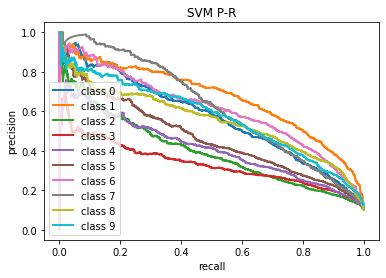

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve
for i in range(10):
    p, r, _ = precision_recall_curve(y_bin_test[:, i], y_pred[:, i])
    plt.plot(r, p, lw=2, label='class {}'.format(i))
    
plt.legend(loc="best")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("SVM P-R")

Text(0.5, 1.0, 'SVM ROC')

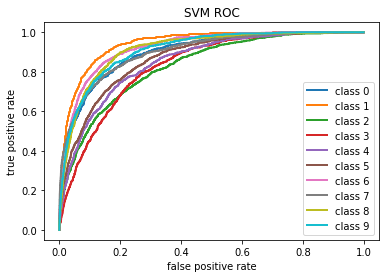

In [38]:
for i in range(10):
    fpr, tpr, _ = roc_curve(y_bin_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, lw=2, label='class {}'.format(i))
    
plt.legend(loc="best")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("SVM ROC")

Text(0.5, 1.0, 'CNN P-R')

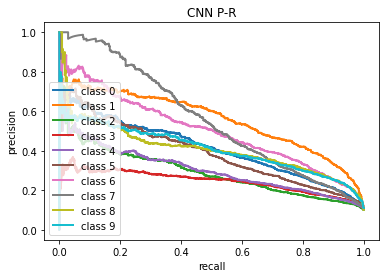

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve
for i in range(10):
    p, r, _ = precision_recall_curve(y_bin_test[:, i], y_zmodelu[:, i])
    plt.plot(r, p, lw=2, label='class {}'.format(i))
    
plt.legend(loc="best")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("CNN P-R")

Text(0.5, 1.0, 'CNN ROC')

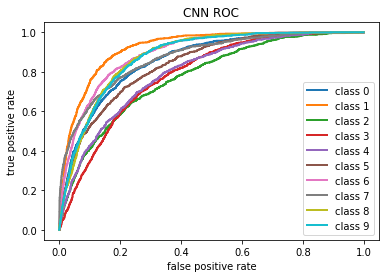

In [40]:
for i in range(10):
    fpr, tpr, _ = roc_curve(y_bin_test[:, i], y_zmodelu[:, i])
    plt.plot(fpr, tpr, lw=2, label='class {}'.format(i))
    
plt.legend(loc="best")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("CNN ROC")